In [1]:
import pandas as pd
import numpy as np

def to_month_id(year, month):
  return (year - 1996) * 12 + month - 6

n_features = 12 # or 54
lookback = 3
chosen_stocks = ["AOL"] # "AMZN", "MSFT", "IBM", "INTC", "QCOM", "NVDA", "IBM", "ADBE", "EBAY", "CSCO"

In [2]:
dfFeature = pd.read_csv("./lstm_2004_12.csv")
# dfFeature.loc[dfFeature["return"] == 0, "return"] = 1
dfFeature = dfFeature[dfFeature.QAId.isin(chosen_stocks)]
features = dfFeature.drop(columns=['month_id', 'QAId']).as_matrix()
print(features.shape)

(157, 12)


In [3]:
from sklearn.preprocessing import MinMaxScaler
normalizedFeatures = MinMaxScaler().fit_transform(features) \
                                   .reshape(157, len(chosen_stocks), n_features) \
                                   .reshape(157, len(chosen_stocks) * n_features)
print(normalizedFeatures.shape)

(157, 12)


In [4]:
dfTarget = pd.read_csv("./return_2004_40.csv")
dfTarget["return"] = np.sign(dfTarget["return"])
# dfTarget.loc[dfTarget["return"] == 0, "return"] = 1
dfTarget = dfTarget[dfTarget.QAId.isin(chosen_stocks)]
dfTarget = dfTarget[dfTarget.month_id >= (to_month_id(2004, 1) + lookback)]
targets = MinMaxScaler().fit_transform(dfTarget.drop(columns=['month_id', 'QAId']).as_matrix())
y = targets.reshape(157 - lookback + 1, len(chosen_stocks))
print(y.shape)

(155, 1)


In [5]:
from keras.preprocessing.sequence import TimeseriesGenerator

splittedFeature = normalizedFeatures
print(splittedFeature.shape)

/Users/billykwok/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(157, 12)


In [6]:
from keras.preprocessing.sequence import TimeseriesGenerator

x = np.zeros((157 - lookback + 1, lookback, n_features * len(chosen_stocks)))
y_mock = np.zeros((157, len(chosen_stocks)))

i = 0
for train, test in TimeseriesGenerator(splittedFeature, y_mock, length=lookback, batch_size=1):
  if i > 157 - lookback:
    break
  x[i] = train[0]
  i = i + 1

In [7]:
from sklearn.model_selection import PredefinedSplit

test_months = 26
end_point = 157 - lookback + 1
split_point = 157 - lookback + 1 - test_months

x_train = x[0:split_point - 48].reshape(split_point - 48, lookback, n_features * len(chosen_stocks))
y_train = y[0:split_point - 48].reshape(split_point - 48, len(chosen_stocks))
x_validate = x[split_point - 36:split_point].reshape(36, lookback, n_features * len(chosen_stocks))
y_validate = y[split_point - 36:split_point].reshape(36, len(chosen_stocks))
x_test = x[split_point:end_point].reshape(test_months, lookback, n_features * len(chosen_stocks))
y_test = y[split_point:end_point].reshape(test_months, len(chosen_stocks))

print(x_train.shape)
print(y_train.shape)
print(x_validate.shape)
print(y_validate.shape)
print(x_test.shape)
print(y_test.shape)

# ps = PredefinedSplit(np.append(np.negative(np.ones(60 * 465)), np.zeros(24 * 465))).split(x_train)

# for train_ids, test_ids in ps:
#   print(str(train_ids) + ", " + str(test_ids))

(81, 3, 12)
(81, 1)
(36, 3, 12)
(36, 1)
(26, 3, 12)
(26, 1)


In [41]:
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, Flatten, CuDNNLSTM
from keras.regularizers import l1_l2, l2
from keras.optimizers import RMSprop, Adam
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

np.random.seed(4103)

def create_model(*param):
    model = Sequential()
    model.add(LSTM(units=256, input_shape=(lookback, n_features * len(chosen_stocks)), return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=64, return_sequences=False))
    model.add(Dropout(0.1))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(len(chosen_stocks), activation="relu"))
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001, decay=0.0), metrics=['accuracy'], *param)
    return model

In [42]:
batch_size=30

model = create_model()
train_score = model.fit(x_train, y_train, validation_data=(x_validate, y_validate), batch_size=batch_size, epochs=200)
print(train_score)

Train on 81 samples, validate on 36 samples
Epoch 1/200
81/81 [==============================] - 3s 42ms/step - loss: 8.5565 - acc: 0.4691 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 2/200
81/81 [==============================] - 0s 760us/step - loss: 8.5565 - acc: 0.4691 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 3/200
81/81 [==============================] - 0s 793us/step - loss: 8.4531 - acc: 0.4691 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 4/200
81/81 [==============================] - 0s 744us/step - loss: 8.3193 - acc: 0.4691 - val_loss: 8.9296 - val_acc: 0.3333
Epoch 5/200
81/81 [==============================] - 0s 722us/step - loss: 5.2865 - acc: 0.4691 - val_loss: 3.7403 - val_acc: 0.3333
Epoch 6/200
81/81 [==============================] - 0s 707us/step - loss: 2.8097 - acc: 0.4691 - val_loss: 3.2362 - val_acc: 0.3333
Epoch 7/200
81/81 [==============================] - 0s 693us/step - loss: 2.4853 - acc: 0.4691 - val_loss: 2.9771 - val_acc: 0.3333
Epoch 8/200
81/81 [====

Epoch 62/200
81/81 [==============================] - 0s 1ms/step - loss: 1.0158 - acc: 0.4691 - val_loss: 1.1973 - val_acc: 0.3333
Epoch 63/200
81/81 [==============================] - 0s 1ms/step - loss: 1.0050 - acc: 0.4691 - val_loss: 1.1778 - val_acc: 0.3333
Epoch 64/200
81/81 [==============================] - 0s 747us/step - loss: 0.9974 - acc: 0.4691 - val_loss: 1.1586 - val_acc: 0.3333
Epoch 65/200
81/81 [==============================] - 0s 760us/step - loss: 0.9616 - acc: 0.4691 - val_loss: 1.1395 - val_acc: 0.3333
Epoch 66/200
81/81 [==============================] - 0s 779us/step - loss: 0.9583 - acc: 0.4691 - val_loss: 1.1202 - val_acc: 0.3333
Epoch 67/200
81/81 [==============================] - 0s 785us/step - loss: 0.9578 - acc: 0.4691 - val_loss: 1.1013 - val_acc: 0.3333
Epoch 68/200
81/81 [==============================] - 0s 794us/step - loss: 0.9269 - acc: 0.4691 - val_loss: 1.0822 - val_acc: 0.3333
Epoch 69/200
81/81 [==============================] - 0s 775us/ste

Epoch 123/200
81/81 [==============================] - 0s 834us/step - loss: 0.6886 - acc: 0.5185 - val_loss: 0.6665 - val_acc: 0.5833
Epoch 124/200
81/81 [==============================] - 0s 822us/step - loss: 0.7000 - acc: 0.5432 - val_loss: 0.6664 - val_acc: 0.5833
Epoch 125/200
81/81 [==============================] - 0s 784us/step - loss: 0.7010 - acc: 0.5062 - val_loss: 0.6663 - val_acc: 0.5833
Epoch 126/200
81/81 [==============================] - 0s 779us/step - loss: 0.6776 - acc: 0.6296 - val_loss: 0.6655 - val_acc: 0.6111
Epoch 127/200
81/81 [==============================] - 0s 780us/step - loss: 0.6705 - acc: 0.5309 - val_loss: 0.6648 - val_acc: 0.6111
Epoch 128/200
81/81 [==============================] - 0s 758us/step - loss: 0.6817 - acc: 0.5185 - val_loss: 0.6648 - val_acc: 0.6111
Epoch 129/200
81/81 [==============================] - 0s 810us/step - loss: 0.6643 - acc: 0.6543 - val_loss: 0.6645 - val_acc: 0.6389
Epoch 130/200
81/81 [==============================] - 

Epoch 184/200
81/81 [==============================] - 0s 866us/step - loss: 0.6609 - acc: 0.6790 - val_loss: 0.6769 - val_acc: 0.5833
Epoch 185/200
81/81 [==============================] - 0s 797us/step - loss: 0.6593 - acc: 0.6296 - val_loss: 0.6759 - val_acc: 0.5833
Epoch 186/200
81/81 [==============================] - 0s 789us/step - loss: 0.6720 - acc: 0.5802 - val_loss: 0.6749 - val_acc: 0.5833
Epoch 187/200
81/81 [==============================] - 0s 802us/step - loss: 0.6446 - acc: 0.6543 - val_loss: 0.6747 - val_acc: 0.5833
Epoch 188/200
81/81 [==============================] - 0s 802us/step - loss: 0.6693 - acc: 0.5802 - val_loss: 0.6734 - val_acc: 0.5278
Epoch 189/200
81/81 [==============================] - 0s 792us/step - loss: 0.6598 - acc: 0.6296 - val_loss: 0.6730 - val_acc: 0.5278
Epoch 190/200
81/81 [==============================] - 0s 809us/step - loss: 0.6805 - acc: 0.5679 - val_loss: 0.6729 - val_acc: 0.5278
Epoch 191/200
81/81 [==============================] - 

26/26 [==============================] - 0s 280us/step
loss: 0.7195595502853394
acc: 0.3461538553237915


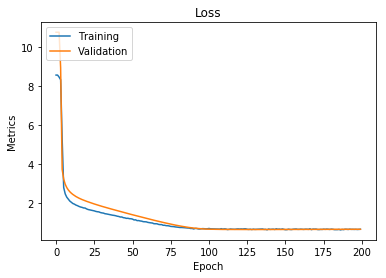

In [43]:
import matplotlib.pyplot as plt

test_score = model.evaluate(x_test, y_test, batch_size=batch_size)
for i, mn in enumerate(model.metrics_names):
  print(mn + ": " + str(test_score[i]))

plt.plot(train_score.history["loss"])
plt.plot(train_score.history["val_loss"])
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Metrics")
plt.legend(["Training", "Validation"], loc="upper left")
plt.show()

In [44]:
from sklearn.metrics import precision_score, recall_score, classification_report

def threshold_tester(result, target, a, b):
  for t in np.arange(a, b + 0.05, 0.05):
    print("thresholder: " + str(t))
    print(classification_report(target, (result >= t).astype(int)))

In [45]:
result = model.predict(x_test, batch_size=batch_size)
print(result)
threshold_tester(result, y_test, 0.1, 0.9)

[[0.519091  ]
 [0.4878207 ]
 [0.44051448]
 [0.45606306]
 [0.43784532]
 [0.4625986 ]
 [0.4965909 ]
 [0.47987875]
 [0.43690395]
 [0.40582985]
 [0.42096534]
 [0.4727516 ]
 [0.4305416 ]
 [0.42704627]
 [0.44702792]
 [0.41906995]
 [0.45179015]
 [0.448288  ]
 [0.46446756]
 [0.48156378]
 [0.46924078]
 [0.43604392]
 [0.46608135]
 [0.5224509 ]
 [0.49373478]
 [0.500103  ]]
thresholder: 0.1
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00         8
        1.0       0.69      1.00      0.82        18

avg / total       0.48      0.69      0.57        26

thresholder: 0.15000000000000002
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00         8
        1.0       0.69      1.00      0.82        18

avg / total       0.48      0.69      0.57        26

thresholder: 0.20000000000000004
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00         8
        1.0    

/Users/billykwok/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [46]:
import math

buy_list = []
sell_list = []

for j, stock in enumerate(chosen_stocks):
  print(stock)
  sorted_result = sorted(map(lambda x: x[j], result))
  midpt = (sorted_result[-2] + sorted_result[1]) / 2
  upper_threshold = midpt * 1.05
  lower_threshold = midpt * 0.95
  
  print("Target\tPredict\tConsequence")
  for i, r in enumerate(result):
    prediction = r[j].item()
    target = y_test[i][j].item()
    buy_or_sell = 1 if prediction > upper_threshold else (-1 if prediction < lower_threshold else 0)
    if prediction > upper_threshold:
      buy_list.append({'month_id': i + 223, 'QAId': stock})
    if prediction < lower_threshold:
      sell_list.append({'month_id': i + 223, 'QAId': stock})
    
    to_print = str(target) + "\t" + str(buy_or_sell)
    if (buy_or_sell == -1 and target == 0) or (buy_or_sell == 1 and target == 1):
      print(to_print + "\tGain")
    elif (buy_or_sell == -1 and target == 1) or (buy_or_sell == 1 and target == 0):
      print(to_print + "\tLoss")
    else:
      print(to_print + "\tNothing")
  print("\n")

print(buy_list)
print(sell_list)

AOL
Target	Predict	Consequence
1.0	1	Gain
1.0	0	Nothing
0.0	-1	Gain
1.0	0	Nothing
1.0	-1	Loss
1.0	0	Nothing
0.0	1	Loss
0.0	0	Nothing
1.0	-1	Loss
0.0	-1	Gain
0.0	-1	Gain
1.0	0	Nothing
0.0	-1	Gain
1.0	-1	Loss
1.0	0	Nothing
1.0	-1	Loss
0.0	0	Nothing
1.0	0	Nothing
1.0	0	Nothing
1.0	0	Nothing
1.0	0	Nothing
1.0	-1	Loss
1.0	0	Nothing
1.0	1	Gain
1.0	1	Gain
0.0	1	Loss


[{'month_id': 223, 'QAId': 'AOL'}, {'month_id': 229, 'QAId': 'AOL'}, {'month_id': 246, 'QAId': 'AOL'}, {'month_id': 247, 'QAId': 'AOL'}, {'month_id': 248, 'QAId': 'AOL'}]
[{'month_id': 225, 'QAId': 'AOL'}, {'month_id': 227, 'QAId': 'AOL'}, {'month_id': 231, 'QAId': 'AOL'}, {'month_id': 232, 'QAId': 'AOL'}, {'month_id': 233, 'QAId': 'AOL'}, {'month_id': 235, 'QAId': 'AOL'}, {'month_id': 236, 'QAId': 'AOL'}, {'month_id': 238, 'QAId': 'AOL'}, {'month_id': 244, 'QAId': 'AOL'}]


In [47]:
dfBuy = pd.DataFrame(buy_list, columns=["month_id", "QAId"])
dfSell = pd.DataFrame(sell_list, columns=["month_id", "QAId"])
dfBuy.head(5)

,month_id,QAId
0,223,AOL
1,229,AOL
2,246,AOL
3,247,AOL
4,248,AOL


In [48]:
dfSell.head(5)

,month_id,QAId
0,225,AOL
1,227,AOL
2,231,AOL
3,232,AOL
4,233,AOL


In [49]:
filename_base = "_".join([stock.lower() for stock in chosen_stocks])
# filename_model = "./" + filename_base + "_model.h5"
# filename_weights = "./" + filename_base + "_weights.h5"
filename_output_buy = "./" + filename_base + "_output_buy.h5"
filename_output_sell = "./" + filename_base + "_output_sell.h5"

# model.save(filename_model)
# model.save_weights(filename_weights)
dfBuy.to_csv(filename_output_buy, index=False)
dfSell.to_csv(filename_output_sell, index=False)

# files.download(filename_model)
# files.download(filename_weights)
# files.download(filename_output_buy)
# files.download(filename_output_sell)